## ICP using simple bunny

In [1]:
!which python

/opt/conda/envs/assembly/bin/python


In [2]:
%matplotlib widget

In [ ]:
from simpleicp import PointCloud, SimpleICP
import numpy as np
import torch

# Read point clouds from xyz files into n-by-3 numpy arrays
X_fix = np.genfromtxt("./example_data/zzz/bunny_part1.xyz")
X_mov = np.genfromtxt("./example_data/zzz/bunny_part2.xyz")
# X_fix = torch.as_tensor(X_fix, dtype=torch.float32).cuda()
# X_mov = torch.as_tensor(X_mov, dtype=torch.float32).cuda()

In [92]:
X_fix.shape, X_mov.shape

((20702, 3), (21637, 3))

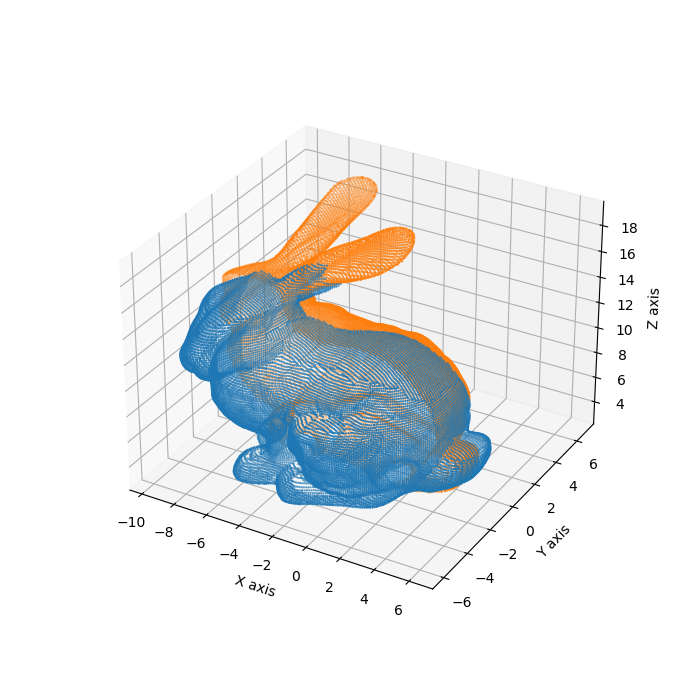

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas

# Extract x, y, and z coordinates

def plot_3d(pts1, pts2):
    if isinstance(pts1, pandas.core.frame.DataFrame):
        pts1 = pts1.to_numpy()
    if isinstance(pts2, pandas.core.frame.DataFrame):
        pts2 = pts2.to_numpy()
    if isinstance(pts1, torch.Tensor) and pts1.is_cuda:
        pts1 = pts1.cpu()
    if isinstance(pts2, torch.Tensor) and pts2.is_cuda:
        pts2 = pts2.cpu()
    
    
    # Set up the figure and axis for the 3D plot
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for the 3D coordinates
    ax.scatter(pts1[:, 0], pts1[:, 1], pts1[:, 2], '.', s=0.3)
    ax.scatter(pts2[:, 0], pts2[:, 1], pts2[:, 2], 'r.', s=0.3)

    # Set labels for the axis
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Display the plot
    plt.show()
    
plot_3d(X_fix, X_mov)

Consider partial overlap of point clouds ...
Select points for correspondences in fixed point cloud ...
Estimate normals of selected points ...
Start iterations ...
iteration | correspondences | mean(residuals) |  std(residuals)
   orig:0 |             863 |          0.0415 |          0.1822
        1 |             862 |          0.0092 |          0.1114
        2 |             774 |          0.0051 |          0.0548
        3 |             808 |          0.0022 |          0.0407
        4 |             824 |          0.0016 |          0.0343
        5 |             824 |          0.0010 |          0.0249
        6 |             810 |          0.0006 |          0.0189
        7 |             784 |          0.0001 |          0.0138
        8 |             765 |          0.0008 |          0.0092
        9 |             753 |          0.0003 |          0.0061
       10 |             735 |          0.0002 |          0.0040
       11 |             742 |         -0.0001 |          0.0032
   

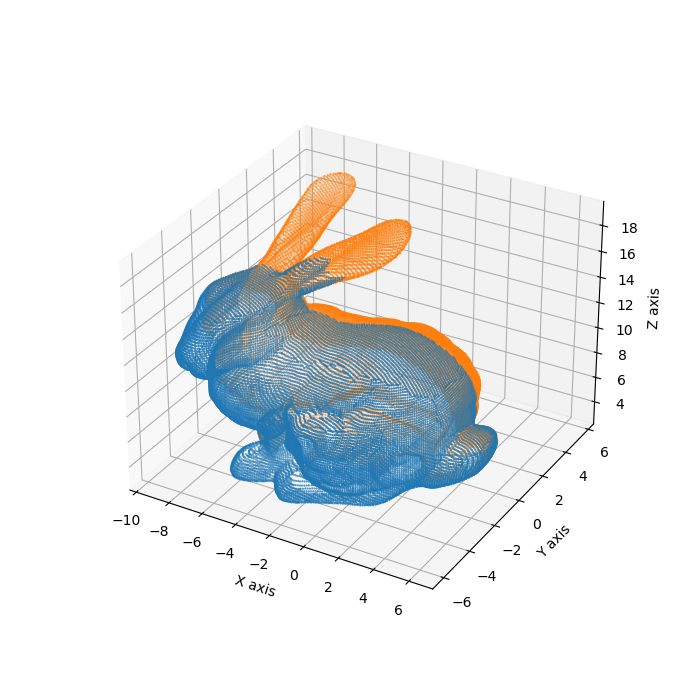

In [94]:
from simpleicp import PointCloud, SimpleICP
import numpy as np
X_fix
# Create point cloud objects
pc_fix = PointCloud(X_fix, columns=["x", "y", "z"])
pc_mov = PointCloud(X_mov, columns=["x", "y", "z"])

# Create simpleICP object, add point clouds, and run algorithm!
icp = SimpleICP()
icp.add_point_clouds(pc_fix, pc_mov)
H, X_mov_transformed, rigid_body_transformation_params = icp.run(max_overlap_distance=1)


plot_3d(X_fix, X_mov_transformed)

In [95]:
import numpy as np

def euler_coord_to_homogeneous_coord(Xe: np.array) -> np.array:
    """Convert Euler coordinates to homogeneous coordinates."""

    no_points = np.shape(Xe)[0]
    Xh = np.column_stack((Xe, np.ones(no_points)))

    return Xh

x = np.arange(9).reshape((3,3))
h_value = euler_coord_to_homogeneous_coord(x)

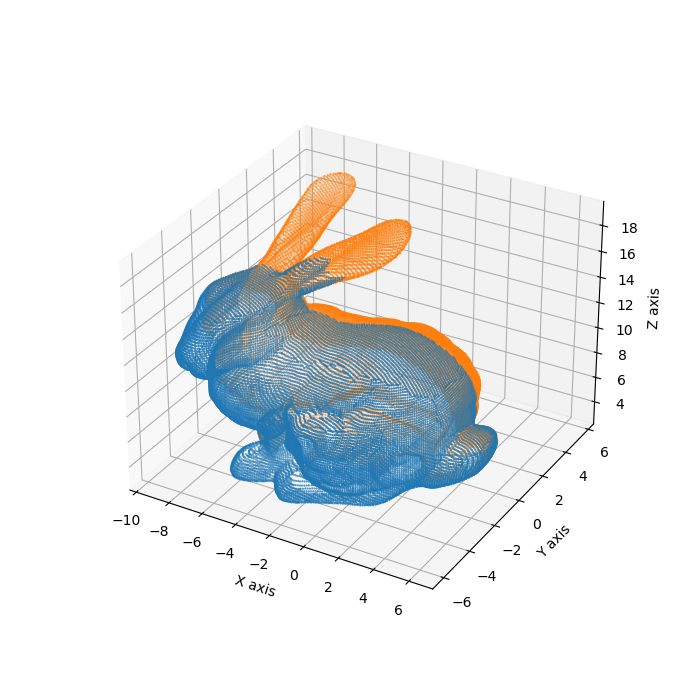

In [96]:

def homogeneous_coord_to_euler_coord(Xh: np.array) -> np.array:
    """Convert homogeneous coordinates to Euler coordinates."""

    return Xh[:, :3]

Xh = euler_coord_to_homogeneous_coord(X_mov)
Xe = (Xh @ H.T)[:, :3]  # transform in-place to save memory


plot_3d(X_fix, Xe)

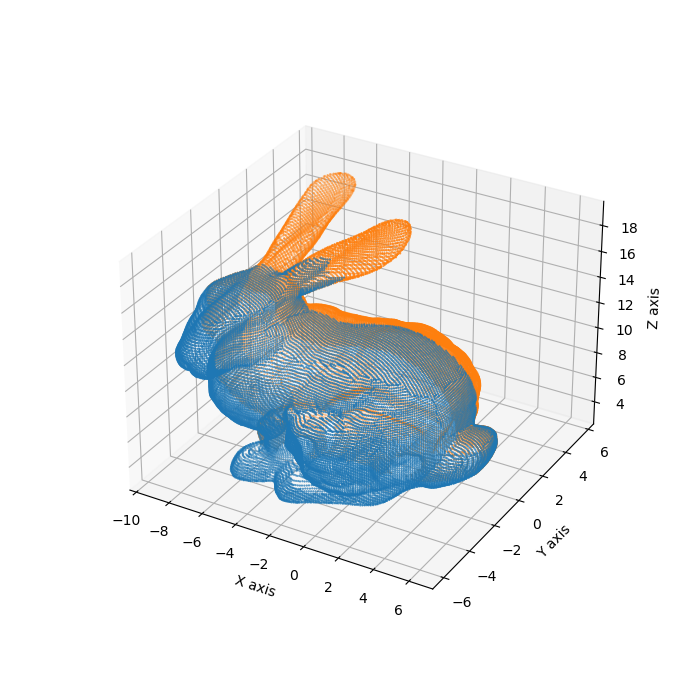

In [98]:
R = H[:3, :3]
T = H[3, :3]
Xe2 = X_mov @ R.T + T

plot_3d(X_fix, Xe2)

In [111]:
torch.tensor(H)



tensor([[ 9.8480e-01, -1.7370e-01, -5.3432e-05,  6.7617e-04],
        [ 1.7370e-01,  9.8480e-01,  8.3840e-05, -1.1500e-03],
        [ 3.8056e-05, -9.1847e-05,  1.0000e+00,  1.1329e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)

tensor([[ 0.9835, -0.1728, -0.0456],
        [ 0.1765,  0.9798,  0.0961],
        [ 0.0282, -0.1026,  0.9943]], device='cuda:0')
tensor([0.0073, 3.1980, 0.0812], device='cuda:0')


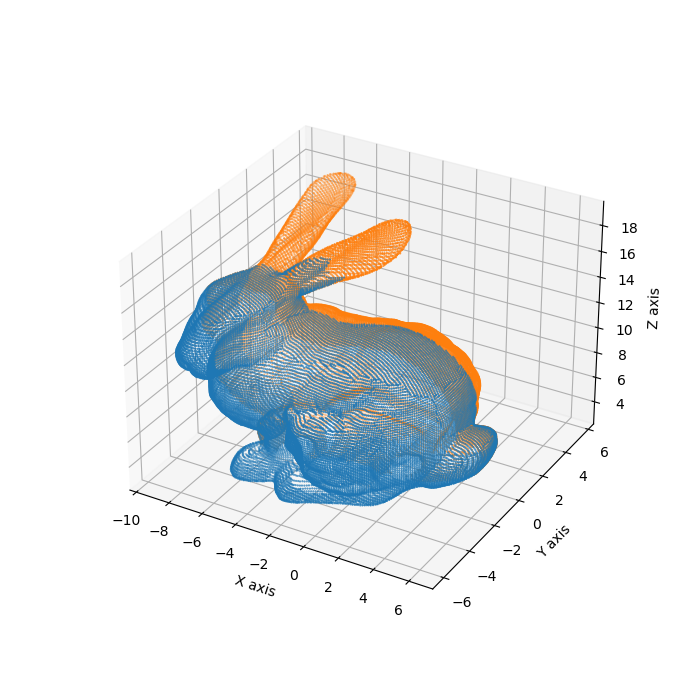

In [117]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pytorch3d.ops.points_alignment import iterative_closest_point

X_fix_tensor = torch.Tensor(X_fix)
X_fix_tensor = X_fix_tensor.reshape((1, ) + X_fix_tensor.shape).to("cuda")
X_mov_tensor = torch.Tensor(X_mov)
X_mov_tensor = X_mov_tensor.reshape((1, ) + X_mov_tensor.shape).to("cuda")

result = iterative_closest_point(X_fix_tensor, X_mov_tensor)

if result.converged:
    rotation = result.RTs.R.reshape(3, 3)
    translation = result.RTs.T[0]
    print(rotation)
    print(translation)
    # X_transformed = X_mov_tensor[0] @ rotation.T
    X_transformed = X_mov_tensor[0].cpu().numpy() @ R.T
    


plot_3d(X_fix, X_transformed)

(tensor([[ 0.9835, -0.1728, -0.0456],
         [ 0.1765,  0.9798,  0.0961],
         [ 0.0282, -0.1026,  0.9943]], device='cuda:1'),
 tensor([0.0073, 3.1980, 0.0812], device='cuda:1'))

In [10]:
import math, torch

angle = math.pi / 4
cos = torch.cos(angle)

TypeError: cos(): argument 'input' (position 1) must be Tensor, not float

In [8]:
X_mov_transformed

array([[-3.73124446, -0.78005762, 12.78997925],
       [-4.44664925, -0.58129404, 12.88992436],
       [-2.18455987, -0.91343419, 12.67007308],
       ...,
       [-7.39727633,  3.71163571, 15.0594068 ],
       [-3.12132298,  0.07918582, 15.36993981],
       [-4.06204798,  0.46159244, 15.35985749]])

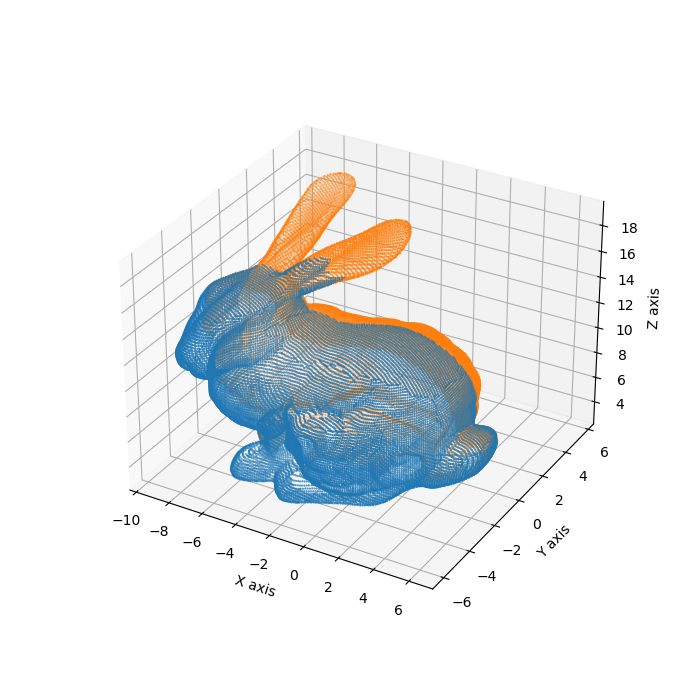

In [7]:
plot_3d(pc_fix, pc_mov)

## ICP for part assembly